# Deep Learning - Heart Disease Prediction
*oriya shapira*

**Data import and arrangement**
- The data set contains information of 1,888 records merged from five publicly available heart disease datasets.
- link to the data source in kaggle - https://www.kaggle.com/datasets/mfarhaannazirkhan/heart-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import random

**Reading the Data**

In [2]:
#Import data from GitHub
url_HeartDisease = 'https://raw.githubusercontent.com/OriyaShapira/DeepLearning-proj/main/cleaned_merged_heart_dataset.csv'
df_HeartDisease = pd.read_csv(url_HeartDisease)
print(df_HeartDisease.shape)
df_HeartDisease.info()

(1888, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   sex       1888 non-null   int64  
 2   cp        1888 non-null   int64  
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   int64  
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   int64  
 9   oldpeak   1888 non-null   float64
 10  slope     1888 non-null   int64  
 11  ca        1888 non-null   int64  
 12  thal      1888 non-null   int64  
 13  target    1888 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 206.6 KB


In [3]:
df_HeartDisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Data Preparation**

Although the selected dataset does not require the complete data preparation process as suggested, I chose to include it for potential use with additional datasets.

In [4]:
def data_preparation(df):
    '''
    This function prepar the data for the process by dealing with missing values or non-fitt column type
    '''
    
    # Dropping missing and inf values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Convert non-numeric columns to numeric
    non_numeric = df.select_dtypes(exclude=["number"]).columns
    df[non_numeric] = df[non_numeric].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

    # Reset indexes in case of row deletion
    df = df.reset_index(drop=True)

    # Split the data to prevent leakage
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    
    return  train, test

In [5]:
def normalization(features):
    '''
    This function is responsible for performing standard normalization on the data.
    '''

    # Only numerical columns getting normalized. 
    numeric_column = ['age', 'chol', 'trestbps', 'thalachh', 'oldpeak']

    # The value range chosen for this project is -1 to 1 to allow for negative values.
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    for feature in numeric_column:
        if feature in features.columns:
            features[feature] = scaler.fit_transform(features[[feature]])
            features[feature] = (features[feature] - features[feature].mean(axis=0)) / features[feature].std(axis=0)
    return features

**Start working on the data**

In [6]:
# Checking for Data Imbalance
LowChance, HighChance = df_HeartDisease.groupby('target').size().items()
AllChance = LowChance[1] + HighChance[1]
print("Percentage of patients with target 0 (low chance): {:.2f}%\n""Percentage of patients with target 1 (high chance): {:.2f}%".format(
          (LowChance[1] / AllChance) * 100,(HighChance[1] / AllChance) * 100))

# Percentage difference
percentage_diff = abs(LowChance[1] - HighChance[1]) / AllChance * 100
if percentage_diff < 20:
    print("The dataset is balanced- there are {:.2f}%"" precentage difference.".format(percentage_diff))
else:
    print("The dataset is unbalanced - there are {:.2f}%"" precentage difference.".format(percentage_diff))

Percentage of patients with target 0 (low chance): 48.25%
Percentage of patients with target 1 (high chance): 51.75%
The dataset is balanced- there are 3.50% precentage difference.


In [7]:
# Using the functions above to prepar the trein and test dataset seperatlly.
train, test = data_preparation(df_HeartDisease)

# Splitting the data into values and targets.
x_train = train.drop(columns=['target'])
x_train = normalization(x_train) # Normalizing the training features
y_train = train['target']

x_test = test.drop(columns=['target'])
x_test = normalization(x_test) # Normalizing the test features
y_test = test['target']

print("Training set features shape:", x_train.shape)
print("Test set features shape:", x_test.shape)
print("Training set target shape:", y_train.shape)
print("Test set target shape:", y_test.shape)

Training set features shape: (1510, 13)
Test set features shape: (378, 13)
Training set target shape: (1510,)
Test set target shape: (378,)


**Data statistics and visualization**

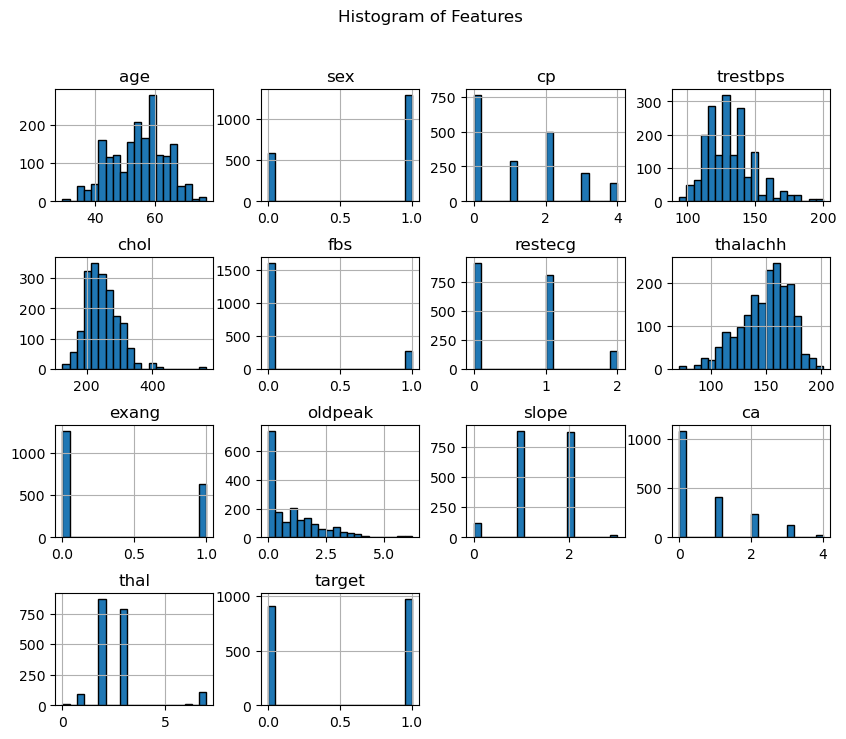

In [8]:
# Features histogram
ax = df_HeartDisease.hist(figsize=(10, 8), bins=20, edgecolor='black')
plt.suptitle("Histogram of Features", fontsize=12)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [9]:
# Data statistics
df_HeartDisease.describe().T.style.format(precision=2).background_gradient(cmap="Pastel1")

,count,mean,std,min,25%,50%,75%,max
age,1888.00,54.35,9.08,29.00,47.75,55.00,61.00,77.00
sex,1888.00,0.69,0.46,0.00,0.00,1.00,1.00,1.00
cp,1888.00,1.28,1.28,0.00,0.00,1.00,2.00,4.00
trestbps,1888.00,131.55,17.56,94.00,120.00,130.00,140.00,200.00
chol,1888.00,246.86,51.61,126.00,211.00,241.00,276.00,564.00
fbs,1888.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
restecg,1888.00,0.60,0.64,0.00,0.00,1.00,1.00,2.00
thalachh,1888.00,149.42,23.01,71.00,133.00,152.00,166.00,202.00
exang,1888.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00
oldpeak,1888.00,1.05,1.16,0.00,0.00,0.80,1.60,6.20


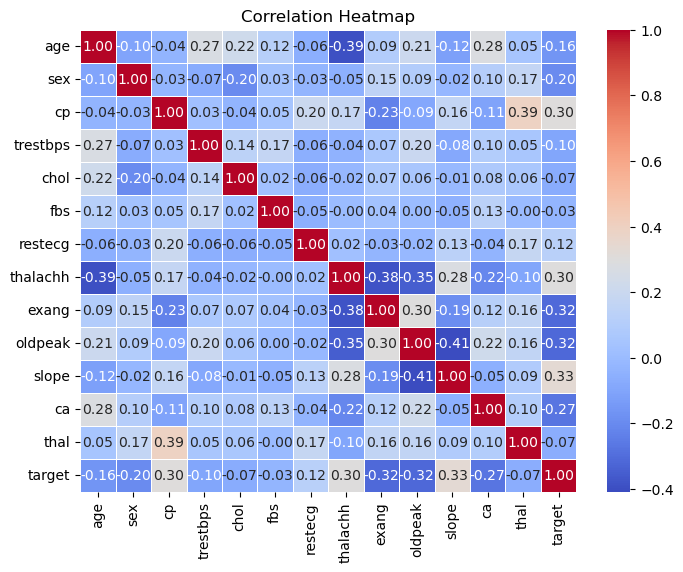

In [10]:
# Feature correlation heat map
correlation_map = df_HeartDisease.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_map, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=12)
plt.show()

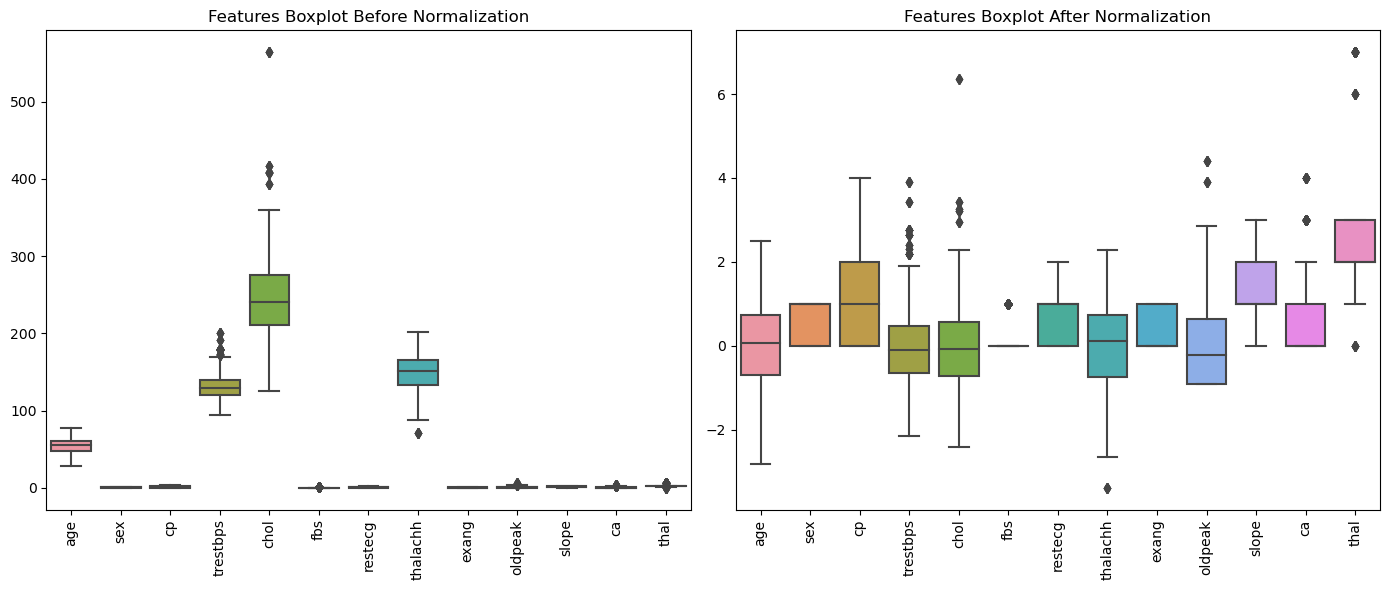

In [11]:
# Plot boxplots for outlier detection
df_visualization = df_HeartDisease.drop(columns=['target'])
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before normalization
sns.boxplot(data=df_visualization, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title('Features Boxplot Before Normalization')

# Plot boxplots for outlier detection in train data after normalization
sns.boxplot(data=x_train, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_title('Features Boxplot After Normalization')

plt.tight_layout()
plt.show()

**Model creation**

In [12]:
def build_model():
    '''
    This function is responsible for defining the model
    '''

    # The model is built using 2 layers containing 34 neurons and 1 output layer.
    model = keras.Sequential([
        keras.layers.Dense(34, activation="relu"),
        keras.layers.Dense(34, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")])
        
    # Compiling the model.
    model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.Recall(name="recall")])
    
    return model

In [13]:
# Early Stopping setup.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3,
    restore_best_weights=True)

In [14]:
# Random Seed setup.
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [15]:
# K-fold validation setup.
k = 4
num_val_samples = len(x_train) // k
num_epochs = 250

In [16]:
# Running the learning process
all_histories = {'loss_histories':[],'recall_histories':[]}

for i in range(k):
    print(f"Processing fold #{i}")

    # Split the training set into train and validation for this fold.
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=56, verbose=0,
                       callbacks=[early_stopping])

    # Evaluate the model and save the evaluation.
    all_histories['loss_histories'].append(history.history["val_loss"])
    all_histories['recall_histories'].append(history.history["val_recall"])

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


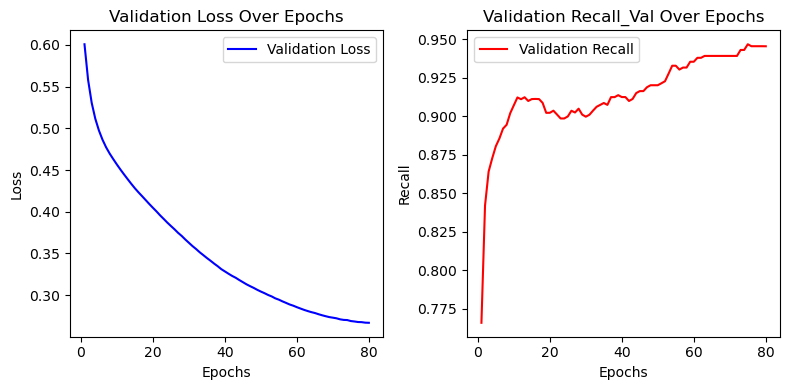

In [17]:
# Since Early Stopping was used, calculating the number of epochs is necessary.
actual_epochs = min(len(history) for history in all_histories['loss_histories'])

# Visual representation of model improvement over epochs.
average_loss_history = [np.mean([x[i] for x in all_histories['loss_histories']]) for i in range(actual_epochs)]
average_recall_history = [np.mean([x[i] for x in all_histories['recall_histories']]) for i in range(actual_epochs)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Loss improvement.
axes[0].plot(range(1, actual_epochs + 1), average_loss_history, label="Validation Loss", color="blue")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Validation Loss Over Epochs")
axes[0].legend()

# Recall improvement.
axes[1].plot(range(1, actual_epochs + 1), average_recall_history, label="Validation Recall", color="red")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Recall")
axes[1].set_title("Validation Recall_Val Over Epochs")
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Training the model again on the full training dataset.
model = build_model()
model.fit(x_train, y_train, epochs=actual_epochs, batch_size=56, shuffle=False)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5553 - loss: 0.6980 - recall: 0.8580
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7317 - loss: 0.5841 - recall: 0.8388
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.5408 - recall: 0.8448 
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7626 - loss: 0.5176 - recall: 0.8460 
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.5009 - recall: 0.8518 
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7729 - loss: 0.4878 - recall: 0.8548 
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 0.4756 - recall: 0.8594 
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.4639 - recall: 0.8706 
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4524 - recall: 0.8756 
Epoch 10/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7896 - loss: 0.4418

In [19]:
# Evaluating the model's performance on the test set.
threshold = 0.35
y_pred = model.predict(x_test)
test_pred = (y_pred >= threshold).astype(int)

accuracy = accuracy_score(y_test, test_pred)
recall = classification_report(y_test, test_pred)

# The model's score across various success metrics.
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", recall)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.8889
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       188
           1       0.85      0.95      0.90       190

    accuracy                           0.89       378
   macro avg       0.90      0.89      0.89       378
weighted avg       0.90      0.89      0.89       378



**Decision Tree**

In [20]:
from sklearn.tree import DecisionTreeClassifier
Comparison_Model = DecisionTreeClassifier()

# Train the model
Comparison_Model.fit(x_train, y_train)

# Predict on the test set
Comparison_pred = np.round(Comparison_Model.predict(x_test))
Comparison_recall =classification_report(y_test, Comparison_pred)
print(Comparison_recall)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       188
           1       0.90      0.95      0.93       190

    accuracy                           0.92       378
   macro avg       0.92      0.92      0.92       378
weighted avg       0.92      0.92      0.92       378



**Comparison between the models**

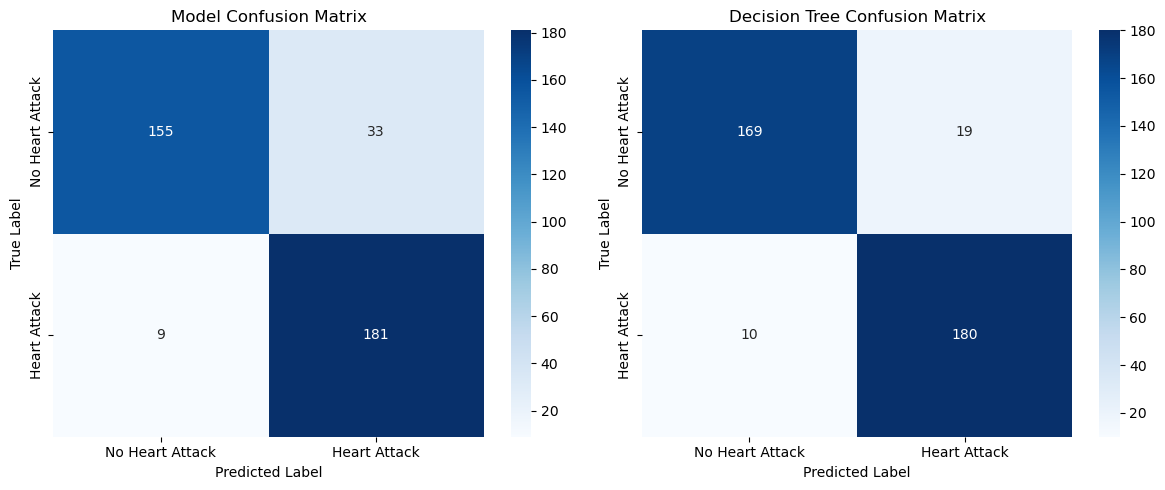

In [21]:
cm_Model = confusion_matrix(y_test, test_pred)
cm_DecisionTree = confusion_matrix(y_test, Comparison_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_Model, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heart Attack", "Heart Attack"],
            yticklabels=["No Heart Attack", "Heart Attack"], ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Model Confusion Matrix")

sns.heatmap(cm_DecisionTree, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heart Attack", "Heart Attack"],
            yticklabels=["No Heart Attack", "Heart Attack"], ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Decision Tree Confusion Matrix")

plt.tight_layout()
plt.show()